Задача: Для розничного магазина разработать систему определения возраста по изображению для предотвращения продажи алкоголя несовершеннолетним, а также предпочтений в покупках. Для обучения модели надо использовать подготовленную базу *APPA-REAL*. 

Условие выполнения: *MAE* < 8.

# Определение возраста покупателей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


## Исследовательский анализ данных

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
display(labels_df.sample(10))

,file_name,real_age
5586,005586.jpg,33
1453,001453.jpg,23
5956,005957.jpg,49
2123,002123.jpg,30
3013,003013.jpg,50
3729,003729.jpg,25
2170,002170.jpg,28
5278,005278.jpg,20
3686,003686.jpg,23
3365,003365.jpg,42


In [3]:
path = '/datasets/faces/'

data_train = pd.read_csv(str(path) + 'labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255,
            validation_split=0.25, 
            horizontal_flip=True, 
            rotation_range=20)

train_data = train_datagen.flow_from_dataframe(
            dataframe=data_train,
            directory=str(path) + 'final_files/',
            target_size=(224, 224),
            x_col='file_name',  
            y_col='real_age',
            batch_size=16,
            class_mode='raw',
            subset='training',
            seed=12345)

data_test = pd.read_csv(str(path) + 'labels.csv')
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

test_data = test_datagen.flow_from_dataframe(
            dataframe=data_test,
            directory=str(path) + 'final_files/',
            target_size=(224, 224),
            x_col='file_name', 
            y_col='real_age',
            batch_size=16,
            class_mode='raw',
            subset='validation',
            seed=12345)
    


Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [4]:
print(f'Тренировочная выборка: {train_data.samples} изображений')
images, labels = next(train_data)
print(f'\nРазмерность батча изображений: {images.shape}')

Тренировочная выборка: 5694 изображений

Размерность батча изображений: (16, 224, 224, 3)


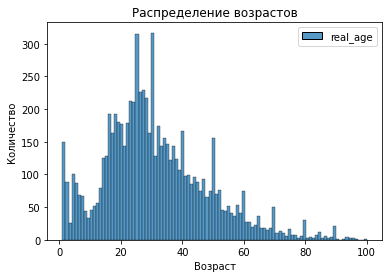

In [5]:
sns.histplot(data = labels_df, bins = 100)
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.title('Распределение возрастов');

В основном в наборе молодые люди, потому что фотографии собирались в интернете.

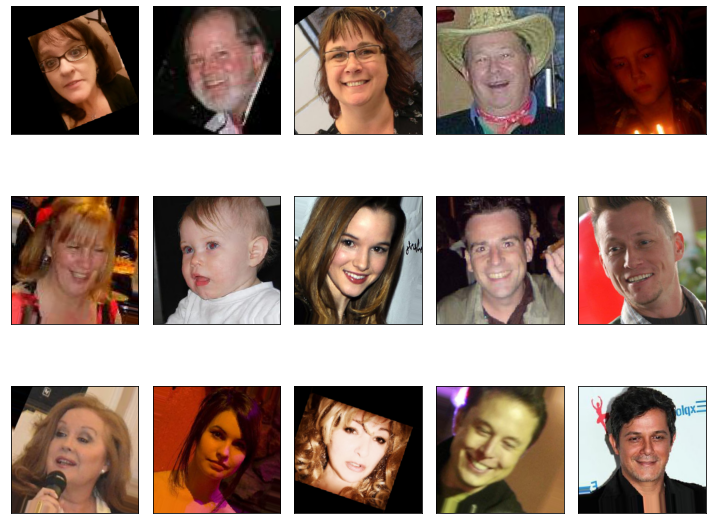

In [6]:
features, target = next(train_data)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели

def load_train(path):
    data = pd.read_csv(str(path) + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
            validation_split=0.25, 
            horizontal_flip=True, 
            rotation_range=20)

    train_data = train_datagen.flow_from_dataframe(
                    dataframe=data,
                    directory=str(path) + 'final_files/',
                    target_size=(224, 224),
                    x_col='file_name',  
                    y_col='real_age',
                    batch_size=16,
                    class_mode='raw',
                    subset='training',
                    seed=12345)
    
    return train_data


def load_test(path):
    data = pd.read_csv(str(path) + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_data = test_datagen.flow_from_dataframe(
                    dataframe=data,
                    directory=str(path) + 'final_files/',
                    target_size=(224, 224),
                    x_col='file_name', 
                    y_col='real_age',
                    batch_size=16,
                    class_mode='raw',
                    subset='validation',
                    seed=12345)
    
    return test_data


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mse', 
                    optimizer=Adam(lr=0.0005), 
                    metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None): 
    model.fit(train_data, 
                    validation_data=test_data,         
                    batch_size=batch_size,         
                    epochs=epochs,         
                    steps_per_epoch=steps_per_epoch,         
                    validation_steps=validation_steps,         
                    verbose=1)   
      
    return model

Вывод модели:

286ms/step - loss: 60.3460 - mae: 5.9967 - val_loss: 92.5058 - val_mae: 7.2663

119/119 - 11s - loss: 96.4810 - **mae: 7.4742**

## Анализ обученной модели

Модель: 
*ResNet50*: 50 слоёв. 

*GlobalAveragePooling2D()*: Преобразует 3D-тензор в 1D.

Выходной слой: *Dense(1, activation='relu')* — один нейрон с *relu*.

Функция потерь *mse*, оптимизатор *Adam* (Скорость обучения = 0.0005).

Данные аугментированны отражением по горизонтали и вращением до 20 градусов.

Пиксели отнормированны от 0 до 1.

Модель получилась слегка переобученной. Тренировочное *MAE* = 5.9967, тестовое *MAE* = 7.4742. Ключевое влияние на модель оказала функция активация *relu* и удаление заморозки.  